In [1]:
#Importing required libraries
import pandas as pd
import numpy as np
from pandas_datareader import data
import requests
from math import sqrt
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [13]:
portfolio = 1e5 #Portfolio total worth of 1 lakh
tscost = 0.005 #Per trade transaction cost of 0.5%, so if two stocks of 30 each are bought, (1+0.005)*2*30 is charged in total
nstocks = 0

stock_list = ['BHEL.NS','ITC.NS','LUPIN.NS','RELIANCE.NS','IBVENTURES.NS'] #Stock list, to add a stock simply
                                                                           #add the ticker according to Yahoo! Finance
for stock in stock_list:
    nstocks+=1          #Calculates number of stocks according to input stock list

In [14]:
#Function to read Data
def readData(ticker, n):
    stocks.append(data.DataReader(ticker, 'yahoo',start='1/1/2015')) #Taking backtesting period as roughly 5 years

In [15]:
def make_ichimoku(x):
    nine_avg = (x['High'].rolling(window=9).max() + x['Low'].rolling(window=9).min())/2
    twentysix_avg = (x['High'].rolling(window=26).max() + x['Low'].rolling(window=26).min())/2
    fiftytwo_avg = (x['High'].rolling(window=52).max() + x['Low'].rolling(window=52).min())/2
    
    x['conversion'] = nine_avg
    x['base'] = twentysix_avg
    x['leading_a'] = ((nine_avg + twentysix_avg)/2).shift(26)
    x['leading_b'] = (fiftytwo_avg).shift(26)
    # Lagging is not calculated separetely.
    
    x['position'] = 0
    

In [19]:
def strategy_ichimoku(x):
    for row in range(len(x)):
        if (x['position'].iloc[row-1] == 0):
            if (x['conversion'].iloc[row-1] <= x['base'].iloc[row-1]) and  (x['conversion'].iloc[row] > x['base'].iloc[row]) and (x['Adj Close'].iloc[row] > max(x['leading_a'].iloc[row],x['leading_b'].iloc[row])) and (x['Adj Close'].iloc[row] > max(x['leading_a'].iloc[row-26],x['leading_b'].iloc[row-26])):
                x['position'].iloc[row] = 1
            if (x['conversion'].iloc[row-1] >= x['base'].iloc[row-1]) and  (x['conversion'].iloc[row] < x['base'].iloc[row]) and (x['Adj Close'].iloc[row] < min(x['leading_a'].iloc[row],x['leading_b'].iloc[row])) and (x['Adj Close'].iloc[row] < min(x['leading_a'].iloc[row-26],x['leading_b'].iloc[row-26])):
                x['position'].iloc[row] = -1
        
        elif (x['position'].iloc[row-1] == 1):
            if(x['Adj Close'].iloc[row-1] > max(x['leading_a'].iloc[row],x['leading_b'].iloc[row]) and (x['Adj Close'].iloc[row] <= max(x['leading_a'].iloc[row],x['leading_b'].iloc[row]))):
               x['position'].iloc[row] = 0
            else :
               x['position'].iloc[row] = 1
        
        else :
            if(x['Adj Close'].iloc[row-1] < min(x['leading_a'].iloc[row],x['leading_b'].iloc[row]) and (x['Adj Close'].iloc[row] >= min(x['leading_a'].iloc[row],x['leading_b'].iloc[row]))):
               x['position'].iloc[row] = 0
            else :
               x['position'].iloc[row] = -1

In [20]:
#Iterating over all the tickers to read data, generate Bollinger Bands and formulate portfolio positions based on strategy
i = 0
stocks = []
for ticker in stock_list:
    readData(ticker,i)
    make_ichimoku(stocks[i])
    strategy_ichimoku(stocks[i])
    i+=1

C:\Users\sadas\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\sadas\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\sadas\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\User

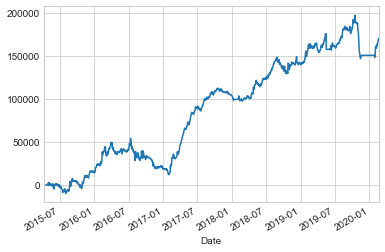

In [23]:
s = (len(stocks[0]),nstocks) #setting the dimensions of the weights vector depending on the available data points
weights = np.zeros(s) 


for row in range(len(stocks[0])):
    i = 0
    sumwts = 0
    for i in range(nstocks):
        sumwts+=np.abs(stocks[i]['position'].iloc[row]) #checking how many positions were taken on that day
    for i in range(nstocks):
        if sumwts>0:
            #weights assigned as:
            #weights = (portfolio*position)/(no.of positions * adj close on that day * (1+transac cost))
            weights[row][i]=(portfolio*stocks[i]['position'].iloc[row])/((sumwts*stocks[i]['Adj Close'].iloc[row])*(1+tscost))
        else:
            weights[row][i]=0
i = 0


for i in range(nstocks):
    stocks[i]['Market Return'] = (stocks[i]['Adj Close'] - stocks[i]['Adj Close'].shift(1)) #Absolute market return

    
#Calculating portfolio return
stocks[0]['Strategy Return']=0
i = 0
for i in range(nstocks):
    stocks[0]['Strategy Return']+=stocks[i]['Market Return'] * weights[:,i] #multiplying market return of each
                                                                            #ticker with its weight
stocks[0]['Strategy Return'][64:].cumsum().plot() #Plotting strategy return